In [16]:
import matplotlib.pyplot as plt
import numpy as np

from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)
import pickle

In [31]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data


In [ ]:
edge_N, bin_N = load_histo("../Dati/Run_chall_Cs_ChargeHistos_4_11_2024_3M.dat")

channel = 6

if(channel == 12 or channel == 13):
    exit()
if(channel > 11):
    channel = channel -2
    
edge_N = edge_N[channel]
bin_N = bin_N[channel]

rebin_fact = 5
bin_N = rebin(bin_N, rebin_fact)
tmp = []
for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)


Text(0, 0.5, 'counts')

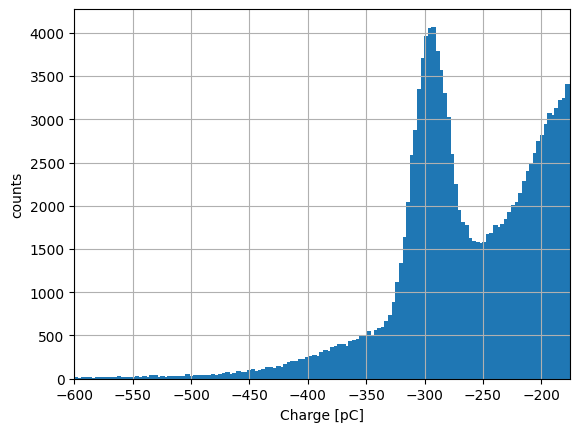

In [44]:
lim_list = [[-700, -165],  #ch0
            [-600, -155],  #ch1
            [-650, -175],  #ch2
            [-600, -145],  #ch3
            [-600, -165],  #ch4
            [-600, -175],  #ch5
            [-600, -155],  #ch6
            [-500, -180],  #ch7
            [-600, -170],  #ch8
            [-600, -160],  #ch9
            [-600, -120],  #ch10
            [-600, -165],  #ch11
            [-600, -140],  #ch14
            [-600, -160]   #ch15
            ]


lim_N = lim_list[channel]
plt.bar(centers_N, bin_N, width = 4)
plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

In [8]:
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude      8835        0      inf    142.2     True     None     None
e1_decay        -89.38   -92.27   -86.48    0.579     True     None     None
ratio            27.03    23.35    30.71   0.7361     True     None     None
s1_amplitude     326.9        0      inf    6.576    False e1_amplitude/ratio     None
s1_center       -400.8   -406.1   -395.6     1.05     True     None     None
s1_sigma         24.04    20.18    27.91   0.7725     True     None     None


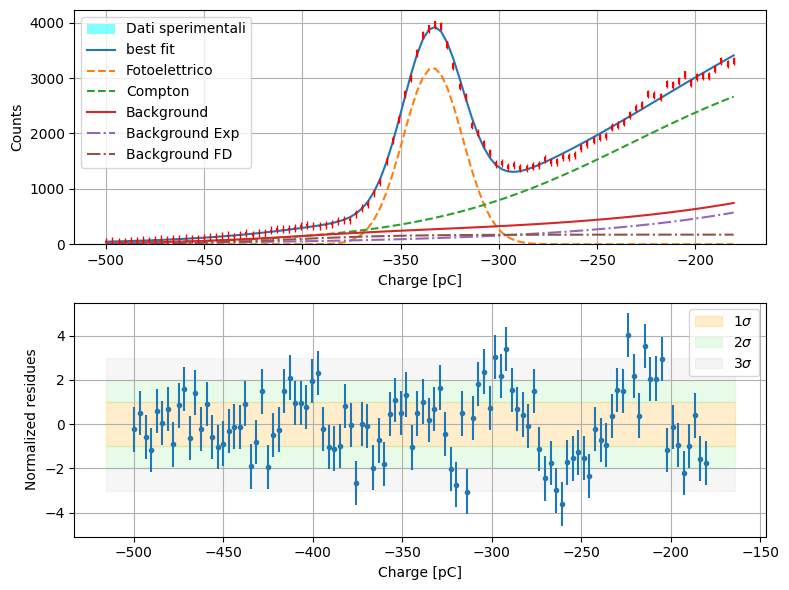

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g2_')) + Model(step, prefix='s1_', form='logistic')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 783
    # data points      = 104
    # variables        = 11
    chi-square         = 248.687001
    reduced chi-square = 2.67405377
    Akaike info crit   = 112.667635
    Bayesian info crit = 141.755935
    R-squared          = 0.99999840
[[Variables]]
    e1_amplitude:  4039.17569 +/- 29891.2032 (740.03%) (init = 1000)
    e1_decay:     -92.2722389 +/- 31.6915428 (34.35%) (init = -89.37712)
    s1_amplitude:  172.997575 +/- 514028.226 (297130.31%) == 'e1_amplitude/ratio'
    s1_center:    -406.082780 +/- 733.962033 (180.74%) (init = -400.832)
    s1_sigma:      27.9060389 +/- 30701.0123 (110015.66%) (init = 24.04369)
    ratio:         23.3481637 +/- 69533.5405 (297811.60%) (init = 27.02862)
    g2_amplitude:  120320.159 +/- 3016.66148

In [27]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
fd1    = ThermalDistributionModel(form = "fermi", prefix = "fd1_") #Fermi Dirac
s1 = StepModel(form = "logistic", prefix = "s1_") #Sigmoide
s2 = StepModel(form = "logistic", prefix = "s2_") #Sigmoide

with open("../DictNoise/NoisesDict_11_04.pkl", "rb") as f:
    x = pickle.load(f)

params=x[channel]

def get_constraints(r, n_sigma):
    r["e1_amplitude"].set(min=0)
    r["e1_decay"].set(value=r["e1_decay"].value, min=r["e1_decay"].value-n_sigma*r["e1_decay"].stderr, max=r["e1_decay"].value+n_sigma*r["e1_decay"].stderr )
    r["s1_center"].set ( value=r["s1_center"].value, min=r["s1_center"].value-n_sigma*r["s1_center"].stderr, max=r["s1_center"].value+n_sigma*r["s1_center"].stderr)
    r["s1_sigma"].set(value=r["s1_sigma"].value, min=r["s1_sigma"].value-n_sigma*r["s1_sigma"].stderr, max=r["s1_sigma"].value+n_sigma*r["s1_sigma"].stderr )
    r["ratio"].set( vary=True, min=r["ratio"].value-n_sigma*r["ratio"].stderr, max=r["ratio"].value+n_sigma*r["ratio"].stderr) 
    r["ratio"].set( vary=True)   
    r["s1_amplitude"].set(expr="e1_amplitude/ratio")
    n_sigma=5
    return r


params=get_constraints(params, n_sigma=5)
params.pretty_print()


params["e1_amplitude"].set(value=1000)

params.update(gauss2.guess(bin_N, x=centers_N))
params["g2_amplitude"].set(vary = True)
params["g2_center"].set(value= -338, vary = True)
params["g2_sigma"].set(value=19, vary = True)

params.update(s2.make_params(amplitude = 0, center = -200, sigma = 50))
params["s2_amplitude"].set( value=100, min=0, vary=True) #"""value=921"""
params["s2_center"].set(value=-250,  vary=True)
params["s2_sigma"].set(value=9,   vary=True)



model = exp1 + gauss2 + s1 + s2  #Per or

# Fit the model to the data
result = model.fit(bin_N, params, x = centers_N, weights = 1 / err_N)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(bin_N, range = lim_N, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centers_N, result.best_fit, label='best fit')
ax1.plot(centers_N, comps['g2_'], label='Fotoelettrico', ls = "--")
ax1.plot(centers_N, comps['s2_'], label='Compton', ls = "--")

ax1.plot(centers_N, comps['e1_'] + comps['s1_'], label='Background')
ax1.plot(centers_N, comps['e1_'], label='Background Exp', ls = "-.")
ax1.plot(centers_N, comps['s1_'], label='Background FD', ls = "-.")

ax1.legend()
ax1.errorbar(centers_N, bin_N, err_N, color = "red", fmt='|')
ax1.grid()

residueCs = bin_N - result.best_fit
norm_resCs = residueCs / err_N

ax2.errorbar(centers_N, norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

print(result.fit_report())

In [28]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data


edge_N, bin_N = load_histo("../Dati/.dat")

channel = 7

if(channel == 12 or channel == 13):
    exit()
if(channel > 11):
    channel = channel -2
    
edge_N = edge_N[channel]
bin_N = bin_N[channel]

rebin_fact = 5
bin_N = rebin(bin_N, rebin_fact)
tmp = []
for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)


IndexError: index 7 is out of bounds for axis 0 with size 1

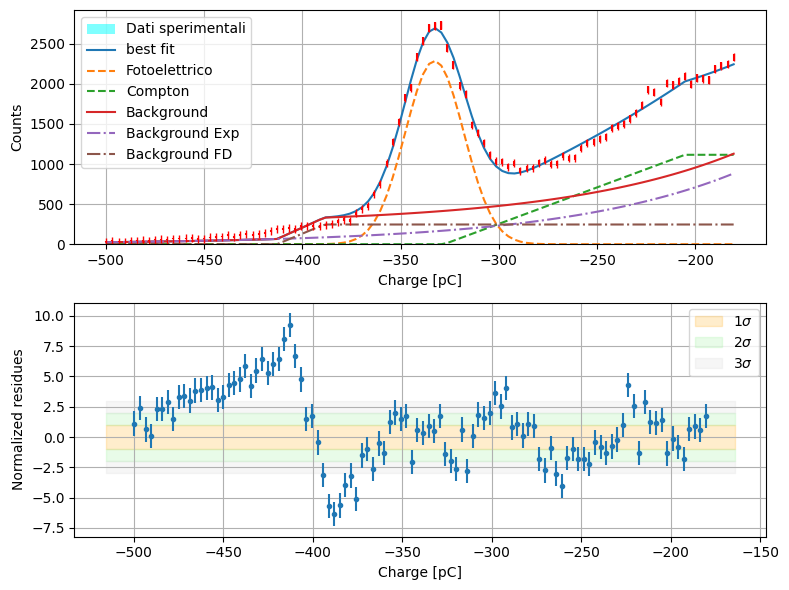

In [105]:


params["s1_sigma"].vary = False   #Blocco i parametri dell'esponenziale e della prima Fermi Dirac
params["s1_center"].vary = False  #lasciando libere le ampiezze
params["e1_decay"].vary = False

params["s2_amplitude"].vary = True  #Sblocco i parametri di Fermi Dirac e seconda gaussiana
params["s2_center"].vary = True
params["s2_sigma"].vary = True
params["g1_amplitude"].vary = True
params["g1_center"].vary = True
params["g1_sigma"].vary = True


#params.add("e1_amplitude", expr = 's1_amplitude * ratio')
#params["e1_amplitude"].expr = 's1_amplitude * ratio'
params["e1_amplitude"].vary = False

params["s1_amplitude"].value = 10

params["g1_amplitude"].value = 425000    #Parametri da aggiustare to make the magic happen
params["g1_center"].min = -350          #Si possono, se serve, specificare canale per canale
params["g1_center"].max = -300
params["g1_center"].set(value = -325)
params["g1_sigma"].set(value = 15)

params["s2_amplitude"].set(value = 5000)
params["s2_center"].set(value = -230)
params["s2_sigma"].set(value = 5)
params["s2_center"].min = -350
params["s2_center"].max = -150

params.update(params)

with open("../DictNoise/NoisesDict_11_04.pkl", "rb") as f:
    noise_params = pickle.load(f)

noise_params = noise_params[channel]

params["s1_amplitude"].value = noise_params["s1_amplitude"].value
params["s1_center"].value = noise_params["s1_center"].value
params["s1_sigma"].value = noise_params["s1_sigma"].value
params["e1_decay"].value = noise_params["e1_decay"].value
params.add("ratio", value = noise_params["ratio"].value)

params["s1_sigma"].vary = False   #Blocco i parametri dell'esponenziale e della prima Fermi Dirac
params["s1_center"].vary = False  #lasciando libere le ampiezze
params["e1_decay"].vary = False
params["ratio"].vary = False
params["e1_amplitude"].vary = False
params["s1_amplitude"].vary = False
params["ratio"].vary = False
params["ratio"].expr = ""

params["s1_amplitude"].vary = True
params["e1_amplitude"].vary = True
params["e1_amplitude"].value = 54057.2496
params["e1_amplitude"].expr = "ratio * s1_amplitude"

params.update(params)

# Fit the model to the data
result = model.fit(bin_N, params, x = centers_N, weights = 1 / err_N)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(bin_N, range = lim_N, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centers_N, result.best_fit, label='best fit')
ax1.plot(centers_N, comps['g1_'], label='Fotoelettrico', ls = "--")
ax1.plot(centers_N, comps['s2_'], label='Compton', ls = "--")

ax1.plot(centers_N, comps['e1_'] + comps['s1_'], label='Background')
ax1.plot(centers_N, comps['e1_'], label='Background Exp', ls = "-.")
ax1.plot(centers_N, comps['s1_'], label='Background FD', ls = "-.")

ax1.legend()
ax1.errorbar(centers_N, bin_N, err_N, color = "red", fmt='|')
ax1.grid()

residueCs = bin_N - result.best_fit
norm_resCs = residueCs / err_N

ax2.errorbar(centers_N, norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

In [101]:
print(result.fit_report())

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(step, prefix='s1_', form='logistic')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 187
    # data points      = 104
    # variables        = 7
    chi-square         = 1032.71132
    reduced chi-square = 10.6465085
    Akaike info crit   = 252.737416
    Bayesian info crit = 271.248152
    R-squared          = 0.99417639
[[Variables]]
    e1_amplitude:  6645.61820 +/- 331.773978 (4.99%) == 'ratio * s1_amplitude'
    e1_decay:     -89.37712 (fixed)
    s1_amplitude:  245.873338 +/- 12.2749115 (4.99%) (init = 326.861)
    s1_center:    -400.832 (fixed)
    s1_sigma:      24.04369 (fixed)
    g1_amplitude:  85807.2741 +/- 3015.73063 (3.51%) (init = 425000)
    g1_center:    -332.696309 +/- 0.58155510 (0.17%) (init = -325)
    g1_sigma:      14.9687331 +/- 0.46806043 (3.13%) (init = 15)
    g1_fwhm:       35.2486721 +/- 1.1

In [99]:
err_N

array([ 5.56776436,  6.40312424,  5.47722558,  5.29150262,  6.63324958,
        6.70820393,  7.14142843,  6.40312424,  7.61577311,  7.74596669,
        7.61577311,  8.24621125,  8.36660027,  8.60232527,  8.71779789,
        8.18535277,  8.42614977,  9.16515139,  9.38083152,  9.69535971,
       10.58300524,  9.59166305, 10.53565375, 11.3137085 , 10.63014581,
       11.26942767, 11.66190379, 12.9614814 , 13.92838828, 13.82027496,
       14.14213562, 13.67479433, 15.06651917, 15.13274595, 14.96662955,
       14.86606875, 15.39480432, 15.84297952, 16.79285562, 17.49285568,
       17.1464282 , 19.59591794, 21.02379604, 21.86321111, 25.05992817,
       27.36786437, 31.78049716, 35.665109  , 39.03844259, 42.73172124,
       44.17012565, 48.3011387 , 50.33885179, 51.95190083, 52.13444159,
       52.23983155, 49.43682838, 47.2546294 , 44.47471192, 43.24349662,
       38.60051813, 37.20215048, 35.59494346, 33.42154993, 32.15587038,
       32.07802986, 31.06444913, 31.78049716, 30.29851482, 30.80